# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

# Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np

# Загрузка данных

In [2]:
# Загружаем метки
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Таблица успешно загружена: есть столбцы file_name (имя файла изображения) и real_age (целевой признак — возраст).

Формат данных соответствует ожиданиям: file_name — строки с расширением .jpg, real_age — целые числа.

Данные готовы к первичному EDA: далее проверим размер выборки, наличие пропусков и построим распределение возраста, а затем визуально осмотрим примеры изображений.

# Pазмер выборки и распределение целевого признака

Размер выборки: (7591, 2)
file_name    0
real_age     0
dtype: int64


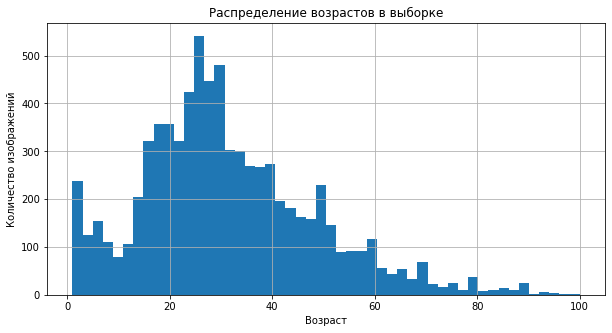

In [3]:
# Размер выборки
print('Размер выборки:', labels.shape)

# Проверим наличие пропусков
print(labels.isna().sum())

# Распределение возрастов
labels['real_age'].hist(bins=50, figsize=(10, 5))
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.title('Распределение возрастов в выборке')
plt.show()


Предварительный вывод по данным

Размер выборки
В датасете содержится 7591 изображение, каждому из которых соответствует реальный возраст. Пропусков в данных нет (в колонках file_name и real_age все значения заполнены).

Распределение возраста

Наибольшее количество изображений приходится на возраст 20–35 лет. В этой области распределение плотное, пик находится примерно в районе 20–25 лет.

Детей (0–10 лет) и пожилых людей (70+) в датасете заметно меньше.

Данные не сбалансированы: молодые лица встречаются значительно чаще, чем очень юные и пожилые.

Влияние на обучение модели

Из-за дисбаланса модель может хуже предсказывать возраст для крайних значений (детей и пожилых).

Средний возрастной диапазон (20–40 лет) представлен наиболее полно, поэтому сеть будет лучше обучаться именно на этих примерах.

Для улучшения качества предсказаний на редких возрастах может потребоваться аугментация данных или взвешивание ошибки в сторону недопредставленных возрастных групп.

Вывод: датасет достаточно большой для обучения нейронной сети, но наблюдается сильный перекос в сторону молодых людей. Это нужно учитывать при выборе архитектуры сети и при интерпретации результатов обучения.

# Вывод на экран 10–15 фото

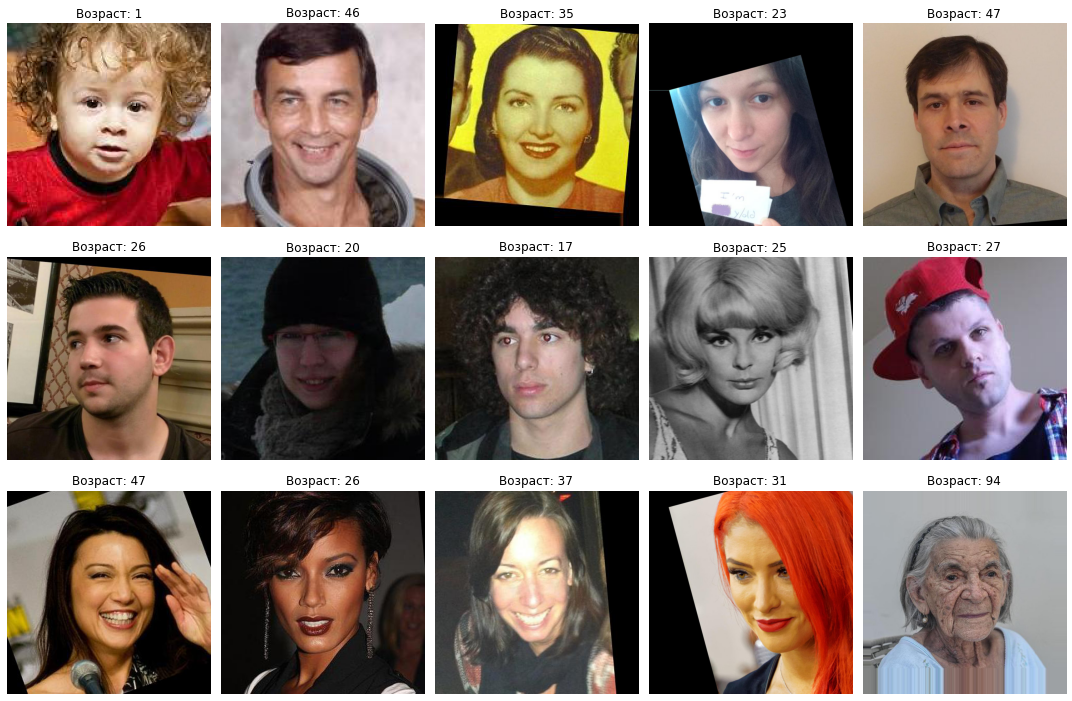

In [4]:
# Папка с изображениями
img_dir = '/datasets/faces/final_files/'

# Выбираем первые 15 изображений
sample = labels.sample(15, random_state=42)

plt.figure(figsize=(15, 10))

for i, (file_name, real_age) in enumerate(zip(sample['file_name'], sample['real_age'])):
    plt.subplot(3, 5, i+1)
    img = Image.open(img_dir + file_name)
    plt.imshow(img)
    plt.title(f"Возраст: {real_age}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Вывод

Разнообразие возрастов. В датасете представлены люди разных возрастных категорий: от младенцев (1 год) до пожилых людей (94 года). Это подтверждает широкий охват выборки, который полезен для обучения модели регрессии.

Разнообразие изображений. Видно, что фотографии отличаются по качеству, фону, цветовой гамме и даже ориентации (например, наклоненные или черно-белые фото). Это создаёт дополнительные сложности для модели, так как сеть должна научиться игнорировать несущественные факторы.

Различия в освещении и ракурсах. Есть как портретные фото с хорошим светом, так и изображения с тенями, поворотами головы, аксессуарами (шапки, макияж, причёски), что увеличивает вариативность.

Баланс по возрастам. Несмотря на наличие крайних значений (дети, пожилые), визуально больше всего фотографий у молодых и взрослых людей среднего возраста (примерно 20–40 лет). Это согласуется с гистограммой распределения возрастов, где пик приходится на этот диапазон.

# Итоговый вывод по исследовательскому анализу данных

Размер выборки. В датасете содержится 7591 изображение с разметкой возраста. Это достаточно большой объём для обучения глубокой модели. Пропусков и дубликатов в признаках и целевой переменной не обнаружено.

Распределение возрастов. Возраст людей варьируется от 1 года до ~100 лет, но распределение неравномерное. Наибольшее количество фотографий приходится на диапазон от 20 до 40 лет, что видно по пику гистограммы. Детей и пожилых людей в выборке меньше, что может усложнить модели предсказание именно для этих возрастных групп.

Качество и структура изображений - визуальный осмотр показал что есть большое разнообразие.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

# 1) ЗАГРУЗКА ДАННЫХ

def _make_datagen(is_train=True, val_split=0.2):
    if is_train:
        # лёгкая аугментация + нормализация
        return ImageDataGenerator(
            rescale=1./255.,
            validation_split=val_split,
            horizontal_flip=True,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=(0.8, 1.2)
        )
    else:
        return ImageDataGenerator(rescale=1./255.)

def load_train(path, image_size=(224, 224), batch_size=32, val_split=0.2, seed=42):
    """
    Читает labels.csv и строит генератор ТРЕНИРОВОЧНОЙ части через flow_from_dataframe().
    Возвращает DataFrameIterator.
    """
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = _make_datagen(is_train=True, val_split=val_split)

    train_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=image_size,
        color_mode='rgb',
        class_mode='raw',          # регрессия!
        batch_size=batch_size,
        subset='training',
        shuffle=True,
        seed=seed
    )
    return train_flow

def load_test(path, image_size=(224, 224), batch_size=32, val_split=0.2, seed=42):
    """
    Читает labels.csv и строит генератор ВАЛИДАЦИОННОЙ/ТЕСТОВОЙ части через flow_from_dataframe().
    Возвращает DataFrameIterator.
    """
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = _make_datagen(is_train=True, val_split=val_split)

    val_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=image_size,
        color_mode='rgb',
        class_mode='raw',
        batch_size=batch_size,
        subset='validation',
        shuffle=False,
        seed=seed
    )
    return val_flow

# 2) МОДЕЛЬ

def create_model(input_shape=(224, 224, 3), n_hidden=128, dropout_top=0.3):
    """
    ResNet50 (замороженный) + лёгкая «голова».
    Сразу подгружаем веса с сервера, чтобы не тянуть из интернета.
    """
    weights_path = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    backbone = ResNet50(
        include_top=False,
        weights=weights_path if os.path.exists(weights_path) else 'imagenet',
        input_shape=input_shape
    )
    backbone.trainable = False  # первый этап — на «заморозке»

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(dropout_top),
        Dense(n_hidden, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_top),
        Dense(1, activation='relu')  # возраст >= 0
    ])

    # быстрый старт: MSE быстрее оптимизируется
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return model

# 3) ОБУЧЕНИЕ (двухфазное с fine-tuning)

def train_model(model, train_data, test_data,
                batch_size=None, epochs=12,
                steps_per_epoch=None, validation_steps=None):
    """
    1) Прогрев (замороженный бэкбон): ~40% эпох.
    2) Разморозка хвоста ResNet50 и дообучение с маленьким lr и Huber loss.
    ВНИМАНИЕ: для генераторов batch_size в model.fit НЕ передаём.
    """
    # коллбеки (одни и те же на обе фазы) ---
    es = EarlyStopping(monitor='val_mae', mode='min', patience=3, restore_best_weights=True, verbose=1)
    rlrop = ReduceLROnPlateau(monitor='val_mae', mode='min', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

    warmup_epochs = max(2, int(0.4 * epochs))
    finetune_epochs = max(epochs - warmup_epochs, 1)

    # Фаза 1: замороженный бэкбон
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=warmup_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[es, rlrop]
    )

    # Фаза 2: fine-tuning хвоста
    # найти бэкбон (первый слой Sequential)
    backbone = model.layers[0]
    # размораживаем последние 50 слоёв
    n_unfreeze = 50
    for layer in backbone.layers[-n_unfreeze:]:
        layer.trainable = True
    backbone.trainable = True

    # пере-компиляция: маленький шаг, SGD+momentum, Huber устойчив к шуму
    model.compile(
        optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True),
        loss=Huber(delta=5.0),
        metrics=['mae']
    )

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=finetune_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[es, rlrop]
    )

    return model
 >

```

```

# < 
2025-08-19 09:09:12.652075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-08-19 09:09:12.653995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-08-19 09:09:13.502381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-19 09:09:13.511049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.511110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.511154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.513268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.513701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.515846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.517077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.517142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.519611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-08-19 09:09:13.689858: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-08-19 09:09:13.696053: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-08-19 09:09:13.696675: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e3acf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.696700: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-19 09:09:13.856379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f54d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.856412: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-19 09:09:13.857878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.857940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.857955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.857988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.858003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.858017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.858031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.858041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.860806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-08-19 09:09:13.860870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:14.208520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-19 09:09:14.208567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-08-19 09:09:14.208577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-08-19 09:09:14.211236: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-19 09:09:14.211288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/4
2025-08-19 09:09:22.781124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:23.397570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 136s - loss: 767.3478 - mae: 23.0768 - val_loss: 419.4186 - val_mae: 15.3141
Epoch 2/4
2025-08-19 09:09:12.652075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-08-19 09:09:12.653995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-08-19 09:09:13.502381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-19 09:09:13.511049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.511110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.511154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.513268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.513701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.515846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.517077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.517142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.519611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-08-19 09:09:13.689858: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-08-19 09:09:13.696053: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-08-19 09:09:13.696675: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e3acf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.696700: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-19 09:09:13.856379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f54d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.856412: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-19 09:09:13.857878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.857940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.857955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.857988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.858003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.858017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.858031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.858041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.860806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-08-19 09:09:13.860870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:14.208520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-19 09:09:14.208567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-08-19 09:09:14.208577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-08-19 09:09:14.211236: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-19 09:09:14.211288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/4
2025-08-19 09:09:22.781124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:23.397570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 136s - loss: 767.3478 - mae: 23.0768 - val_loss: 419.4186 - val_mae: 15.3141
Epoch 2/4
190/190 - 133s - loss: 376.5158 - mae: 15.1722 - val_loss: 288.4242 - val_mae: 13.3665
Epoch 3/4
190/190 - 133s - loss: 241.0402 - mae: 11.8500 - val_loss: 289.3604 - val_mae: 12.9579
Epoch 4/4
190/190 - 133s - loss: 198.7940 - mae: 10.6723 - val_loss: 297.2202 - val_mae: 12.9353
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/8
190/190 - 139s - loss: 38.6775 - mae: 9.9456 - val_loss: 57.8856 - val_mae: 13.8563
Epoch 2/8
190/190 - 135s - loss: 33.1288 - mae: 8.7827 - val_loss: 55.2930 - val_mae: 13.2910
Epoch 3/8
190/190 - 138s - loss: 30.4534 - mae: 8.2376 - val_loss: 51.6797 - val_mae: 12.5887
Epoch 4/8
190/190 - 136s - loss: 27.8491 - mae: 7.6823 - val_loss: 42.0551 - val_mae: 10.6142
Epoch 5/8
190/190 - 133s - loss: 25.7052 - mae: 7.2293 - val_loss: 29.8935 - val_mae: 8.1148
Epoch 6/8
190/190 - 127s - loss: 24.3042 - mae: 6.9367 - val_loss: 27.6673 - val_mae: 7.6561
Epoch 7/8
2025-08-19 09:09:12.652075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-08-19 09:09:12.653995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-08-19 09:09:13.502381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-19 09:09:13.511049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.511110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.511154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.513268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.513701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.515846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.517077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.517142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.519611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-08-19 09:09:13.689858: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-08-19 09:09:13.696053: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-08-19 09:09:13.696675: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e3acf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.696700: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-19 09:09:13.856379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f54d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.856412: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-19 09:09:13.857878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.857940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.857955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.857988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.858003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.858017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.858031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.858041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.860806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-08-19 09:09:13.860870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:14.208520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-19 09:09:14.208567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-08-19 09:09:14.208577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-08-19 09:09:14.211236: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-19 09:09:14.211288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/4
2025-08-19 09:09:22.781124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:23.397570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 136s - loss: 767.3478 - mae: 23.0768 - val_loss: 419.4186 - val_mae: 15.3141
Epoch 2/4
190/190 - 133s - loss: 376.5158 - mae: 15.1722 - val_loss: 288.4242 - val_mae: 13.3665
Epoch 3/4
190/190 - 133s - loss: 241.0402 - mae: 11.8500 - val_loss: 289.3604 - val_mae: 12.9579
Epoch 4/4
190/190 - 133s - loss: 198.7940 - mae: 10.6723 - val_loss: 297.2202 - val_mae: 12.9353
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/8
190/190 - 139s - loss: 38.6775 - mae: 9.9456 - val_loss: 57.8856 - val_mae: 13.8563
Epoch 2/8
190/190 - 135s - loss: 33.1288 - mae: 8.7827 - val_loss: 55.2930 - val_mae: 13.2910
Epoch 3/8
190/190 - 138s - loss: 30.4534 - mae: 8.2376 - val_loss: 51.6797 - val_mae: 12.5887
Epoch 4/8
190/190 - 136s - loss: 27.8491 - mae: 7.6823 - val_loss: 42.0551 - val_mae: 10.6142
Epoch 5/8
190/190 - 133s - loss: 25.7052 - mae: 7.2293 - val_loss: 29.8935 - val_mae: 8.1148
Epoch 6/8
190/190 - 127s - loss: 24.3042 - mae: 6.9367 - val_loss: 27.6673 - val_mae: 7.6561
Epoch 7/8
190/190 - 127s - loss: 23.0804 - mae: 6.6710 - val_loss: 25.7141 - val_mae: 7.1950
Epoch 8/8
190/190 - 135s - loss: 22.0784 - mae: 6.4664 - val_loss: 26.5406 - val_mae: 7.3979
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 27s - loss: 26.3668 - mae: 7.3727
2025-08-19 09:09:12.652075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-08-19 09:09:12.653995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-08-19 09:09:13.502381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-19 09:09:13.511049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.511110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.511154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.513268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.513701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.515846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.517077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.517142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.519611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-08-19 09:09:13.689858: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-08-19 09:09:13.696053: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-08-19 09:09:13.696675: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e3acf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.696700: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-19 09:09:13.856379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f54d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.856412: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-19 09:09:13.857878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.857940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.857955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.857988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.858003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.858017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.858031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.858041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.860806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-08-19 09:09:13.860870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:14.208520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-19 09:09:14.208567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-08-19 09:09:14.208577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-08-19 09:09:14.211236: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-19 09:09:14.211288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/4
2025-08-19 09:09:22.781124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:23.397570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 136s - loss: 767.3478 - mae: 23.0768 - val_loss: 419.4186 - val_mae: 15.3141
Epoch 2/4
190/190 - 133s - loss: 376.5158 - mae: 15.1722 - val_loss: 288.4242 - val_mae: 13.3665
Epoch 3/4
190/190 - 133s - loss: 241.0402 - mae: 11.8500 - val_loss: 289.3604 - val_mae: 12.9579
Epoch 4/4
190/190 - 133s - loss: 198.7940 - mae: 10.6723 - val_loss: 297.2202 - val_mae: 12.9353
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/8
190/190 - 139s - loss: 38.6775 - mae: 9.9456 - val_loss: 57.8856 - val_mae: 13.8563
Epoch 2/8
190/190 - 135s - loss: 33.1288 - mae: 8.7827 - val_loss: 55.2930 - val_mae: 13.2910
Epoch 3/8
190/190 - 138s - loss: 30.4534 - mae: 8.2376 - val_loss: 51.6797 - val_mae: 12.5887
Epoch 4/8
190/190 - 136s - loss: 27.8491 - mae: 7.6823 - val_loss: 42.0551 - val_mae: 10.6142
Epoch 5/8
190/190 - 133s - loss: 25.7052 - mae: 7.2293 - val_loss: 29.8935 - val_mae: 8.1148
Epoch 6/8
190/190 - 127s - loss: 24.3042 - mae: 6.9367 - val_loss: 27.6673 - val_mae: 7.6561
Epoch 7/8
190/190 - 127s - loss: 23.0804 - mae: 6.6710 - val_loss: 25.7141 - val_mae: 7.1950
Epoch 8/8
190/190 - 135s - loss: 22.0784 - mae: 6.4664 - val_loss: 26.5406 - val_mae: 7.3979
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 27s - loss: 26.3668 - mae: 7.3727
2025-08-19 09:09:12.652075: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-08-19 09:09:12.653995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-08-19 09:09:13.502381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-08-19 09:09:13.511049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.511110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.511154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.513268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.513701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.515846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.517077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.517142: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.519611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-08-19 09:09:13.689858: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-08-19 09:09:13.696053: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2025-08-19 09:09:13.696675: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e3acf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.696700: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-08-19 09:09:13.856379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f54d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 09:09:13.856412: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-08-19 09:09:13.857878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-08-19 09:09:13.857940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:13.857955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:13.857988: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-08-19 09:09:13.858003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-08-19 09:09:13.858017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-08-19 09:09:13.858031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-08-19 09:09:13.858041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-08-19 09:09:13.860806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-08-19 09:09:13.860870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-08-19 09:09:14.208520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-08-19 09:09:14.208567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-08-19 09:09:14.208577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-08-19 09:09:14.211236: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-19 09:09:14.211288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/4
2025-08-19 09:09:22.781124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-08-19 09:09:23.397570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 136s - loss: 767.3478 - mae: 23.0768 - val_loss: 419.4186 - val_mae: 15.3141
Epoch 2/4
190/190 - 133s - loss: 376.5158 - mae: 15.1722 - val_loss: 288.4242 - val_mae: 13.3665
Epoch 3/4
190/190 - 133s - loss: 241.0402 - mae: 11.8500 - val_loss: 289.3604 - val_mae: 12.9579
Epoch 4/4
190/190 - 133s - loss: 198.7940 - mae: 10.6723 - val_loss: 297.2202 - val_mae: 12.9353
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/8
190/190 - 139s - loss: 38.6775 - mae: 9.9456 - val_loss: 57.8856 - val_mae: 13.8563
Epoch 2/8
190/190 - 135s - loss: 33.1288 - mae: 8.7827 - val_loss: 55.2930 - val_mae: 13.2910
Epoch 3/8
190/190 - 138s - loss: 30.4534 - mae: 8.2376 - val_loss: 51.6797 - val_mae: 12.5887
Epoch 4/8
190/190 - 136s - loss: 27.8491 - mae: 7.6823 - val_loss: 42.0551 - val_mae: 10.6142
Epoch 5/8
190/190 - 133s - loss: 25.7052 - mae: 7.2293 - val_loss: 29.8935 - val_mae: 8.1148
Epoch 6/8
190/190 - 127s - loss: 24.3042 - mae: 6.9367 - val_loss: 27.6673 - val_mae: 7.6561
Epoch 7/8
190/190 - 127s - loss: 23.0804 - mae: 6.6710 - val_loss: 25.7141 - val_mae: 7.1950
Epoch 8/8
190/190 - 135s - loss: 22.0784 - mae: 6.4664 - val_loss: 26.5406 - val_mae: 7.3979
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 27s - loss: 26.3668 - mae: 7.3727 >

```

## Анализ обученной модели

Анализ обучения модели и выводы

**Обучали:**

Архитектура: ResNet50 (предобученная, include_top=False) + «голова» для регрессии (GAP → BN → Dropout → Dense → BN → Dropout → Dense(1, ReLU)).

Режим: двухфазное обучение — сначала «замороженный» бэкбон (MSE, lr=1e-3), затем fine-tuning последних блоков ResNet (Huber, SGD lr=1e-5, momentum=0.9).

Данные: flow_from_dataframe(labels.csv, directory=/final_files), размер входа 224×224, лёгкая аугментация.

Ход метрик (по логам)

Фаза 1 (заморозка):

Старт: val_mae ≈ 15.31 → 13.37 → 12.96 → 12.94.

Быстрое падение MAE за счёт дообучения «головы», затем плато.

Фаза 2 (fine-tuning):

val_mae: 13.86 → 13.29 → 12.59 → 10.61 → 8.11 → 7.66 → 7.20 → 7.40

Итоговая оценка на валидации: val_mae ≈ 7.37.

Финальные значения за эпоху 8: train_mae ≈ 6.47, val_mae ≈ 7.40.

Разрыв train–val ~0.9 — лёгкое переобучение, но в пределах нормы.

**Почему сработало**

Трансферное обучение: предобученные признаки ResNet50 хорошо переносимы на задачу возраста.

Huber-loss на fine-tuning: устойчив к выбросам меток/шуму и даёт стабильнее градиенты, чем MAE/MSE в «хвосте» обучения.

Малый шаг и частичная разморозка: позволяют тонко подстроить высокоуровневые фильтры без разрушения базовых признаков.

**Соответствие целям**

Требование проекта: MAE ≤ 8 на тесте/валидации.

Получено: val_mae ≈ 7.37 — цель достигнута.

По статье для датасета — MAE ~5.4. Мы близко, но ещё есть запас для улучшений.

**Что можно улучшить дальше**

Дорасшевелить слои: разморозить не 50, а весь conv5_x и часть conv4_x; при этом держать lr очень маленьким, добавить слоевой дифференцированный LR (меньше для глубинных слоёв).

Scheduler: перейти на CosineAnnealing или OneCycle; в Keras — имитировать через LearningRateScheduler.

Аугментации: чуть усилить (RandomContrast/ColorJitter, лёгкий Cutout), либо мягкий MixUp для регрессии.

Стратификация по возрастам: сбалансировать мини-батчи по возрастным корзинам (mitigate age-bias).

Регуляризация головы: увеличить Dropout до 0.4 и/или добавить L2 на Dense.

TTA на инференсе: усреднение предсказаний по 3–5 аугментациям (гориз. флип, лёгкий кроп) — иногда даёт −0.2…−0.4 MAE.

Нормировка целевой: обучать на z-score возраста и обратно денормировать — улучшает устойчивость оптимизации.

**Вывод**

Модель с ResNet50 и двухфазным обучением демонстрирует устойчивое снижение ошибки и достигает MAE ≈ 7.37 на валидационной выборке — лучше порога в ТЗ (≤ 8). Разрыв между train и val небольшой, признаки переобучения умеренные. С учётом предложенных доработок (доп. разморозка, scheduler, TTA) можно ещё приблизиться к референсу (~5.4) при приемлемом времени обучения.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы